In [1]:
%config Completer.use_jedi = False

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartoplot import cartoplot
import mask
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr
import matplotlib.animation as animation
from IPython import display
import tqdm
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.interpolate import cross_section
from metpy.units import units
import pickle
from netCDF4 import Dataset
import numpy as np
from ll_xy import lonlat_to_xy
import datetime
import matplotlib.ticker as mticker
from calendar import monthrange
from pyproj import Proj, Transformer
from cartopy.util import add_cyclic_point
from regrid import regrid
import metpy.calc as mpcalc
import pyproj as proj

/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


In [3]:
with Dataset('/media/robbie/Brokendrive/E5/ERA_nh_1973_12.nc') as ERA5_data:
    lons = np.array(ERA5_data['longitude'])
    lats = np.array(ERA5_data['latitude'])
    
ERA5_lon_grid = np.array([np.array(lons), ] * 121)

ERA5_lat_grid = np.array([np.array(lats), ] * 1440).T

# Process pressure data

In [4]:
data_dir = '/home/robbie/Dropbox/beaufort_sea/monthly_mean_slp/'

def get_mean_slp(year,month,masked=False):
    
    var = 'mean_slps_m' if masked else 'mean_slps'
    
    slp_data = pickle.load(open(f'{data_dir}{year}_mean_slp.p','rb'))

    times_month = slp_data['times'][month]
    slps_month = slp_data[var][month]  
    
    t0 = datetime.datetime(1900,1,1)

    real_times = [t0 + datetime.timedelta(hours=int(s)) for s in times_month]
    
    return(list(slps_month), real_times)

def get_winter_slp(year,masked=False):

    slp_winter, time_winter = [], []

    for month in [12,1,2]:
        
        get_year = year if month in [1,2] else year-1
#         get_year = year
        
        slp_data, time_data = get_mean_slp(get_year,month,masked=masked)
        
        slp_winter += slp_data 
        time_winter += time_data 
        
    return(slp_winter, time_winter)
        
    
# Get Jan 2021 max

fp, ft = get_mean_slp(2021,2)

fmax = np.max(fp)

f_ind_max = np.argmax(fp)

print(fmax)
print(f_ind_max)

103222.70350171713
80


In [23]:
wints = {}

for year in range(1980,2022):
    wints[year] = get_winter_slp(year,masked=False)
    
pickle.dump(wints, open('../figure1_current/winter_SLPS.p','wb'))



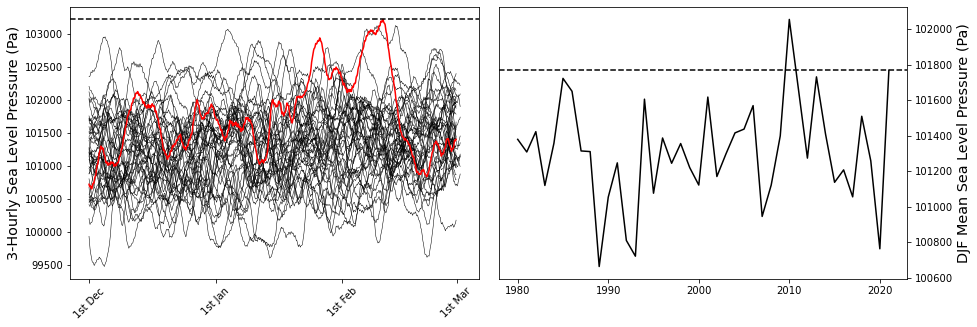

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

djf_mean_slps = []
maxes = []

for year in range(1980,2022):    

    slps_winter, real_times = wints[year]
    
    if year == 2021:
        color = 'r'
        lw = 1.5
    else:
        color = 'k'
        lw=0.5
    
    ax1.plot(slps_winter,color=color, lw=lw)
    
    djf_mean_slps.append(np.mean(slps_winter))
    maxes.append(np.max(slps_winter))
    
fmax = np.max(maxes)
ax1.axhline(fmax, color='k', ls='--')

ax1.tick_params('x',rotation=45)

ax1.set_xticks([0,(31)*8,(31+31)*8,(31+31+28)*8])
ax1.set_xticklabels(['1st Dec', '1st Jan', '1st Feb', '1st Mar'])
ax1.set_ylabel('3-Hourly Sea Level Pressure (Pa)', fontsize='x-large')

ax2.plot(range(1980,2022), djf_mean_slps,color='k')
# ax2.plot(range(1980,2022), feb_mean_slps,color='r')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.axhline(djf_mean_slps[-1], color='k',ls='--')
ax2.set_ylabel('DJF Mean Sea Level Pressure (Pa)', fontsize='x-large')

plt.subplots_adjust(wspace=0.05)

2021-02-11 00:00:00
103222.70350171713


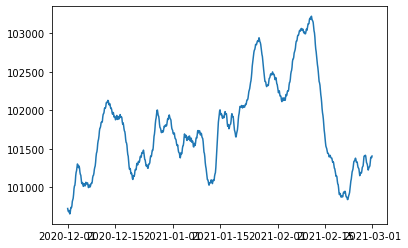

In [8]:
plt.plot(real_times,slps_winter)
print(real_times[np.argmax(slps_winter)])
print(np.max(slps_winter))

In [9]:
def get_slp_pattern(year,month):
        
    slp_data = pickle.load(open(f'{data_dir}{year}_mean_slp.p','rb'))

    slp_pattern = slp_data['mean_slp_pattern'][month]  
    
    return(slp_pattern)

def get_winter_slp_pattern(year):

    slp_winter = []

    for month in [12,1,2]:
        
        get_year = year if month in [1,2] else year-1
        
        slp_pattern = get_slp_pattern(get_year,month)
        
        slp_winter.append(slp_pattern)
        
    slp_pattern_winter = np.average(slp_winter, axis=0, weights=(31,31,28))
        
    return(slp_pattern_winter)

ps = []
for year in np.arange(1980,2021):

    ps.append(get_winter_slp_pattern(year))
    
climatology_p = np.average(ps,axis=0)

In [10]:
np.max(climatology_p)

102762.29313563998

In [11]:
lons

array([-180.  , -179.75, -179.5 , ...,  179.25,  179.5 ,  179.75],
      dtype=float32)

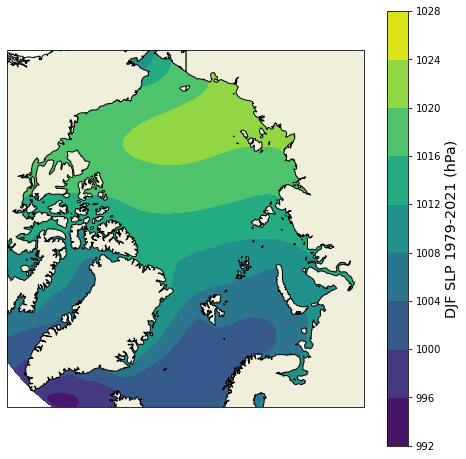

In [12]:
fig = plt.figure(figsize=(8,8))

ax = plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_latitude=90))

ax.set_extent([-180, 180, 90, 66], ccrs.PlateCarree())

cyclic_climatology_p, cyclic_lons = add_cyclic_point(climatology_p, coord=lons)


c = ax.contourf(cyclic_lons,
            lats,
            cyclic_climatology_p/100,
            transform=ccrs.PlateCarree())

ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)

cb = plt.colorbar(c)

cb.set_label('DJF SLP 1979-2021 (hPa)', fontsize='x-large')

overleaf_dir = '/home/robbie/Dropbox/Apps/Overleaf/Beaufort'
plt.savefig(f'{overleaf_dir}/Sup_figs/SLP_climatology.jpg',dpi=500,bbox_inches='tight')

plt.show()

In [13]:
elons, elats = mask.get('lon'), mask.get('lat')

ease_dx, ease_dy = mpcalc.lat_lon_grid_deltas(elons, elats)

WGS_Proj = 'EPSG:4326'
EASE_Proj = 'EPSG:3408'

transformer = Transformer.from_crs(WGS_Proj, EASE_Proj)

xout, yout = transformer.transform(np.array(elons),np.array(elats))

ease_dx = abs(ease_dx); ease_dy = abs(ease_dy)

In [14]:
ERA_mask = regrid(mask.get('mask'),elons,elats,ERA5_lon_grid,ERA5_lat_grid)

def mask_basin(data):

    m = np.ma.masked_where(np.isin(ERA_mask,[8,
                                                9,
                                                10,11,12,13,15],invert=True), data)
    m = np.ma.filled(m, np.nan)
    
    return(m)

import itertools
def check_surroundings(array, inds):
    
    surroundings = []
    for i, j in itertools.product([-1,0,1],[-1,0,1]):
        surroundings.append(array[inds[0]+i,inds[1]+j])
        
    if np.isnan(surroundings).any():
        return(True)
    else:
        return(False)

In [15]:
years = np.arange(1980,2022)

winter_slp_patterns = {}
winter_lap_patterns = {}

for year in tqdm.tqdm(years):
    
    slp_pat = get_winter_slp_pattern(year)
    
    winter_slp_patterns[year] = mask_basin(slp_pat)

100%|██████████| 42/42 [00:00<00:00, 122.86it/s]


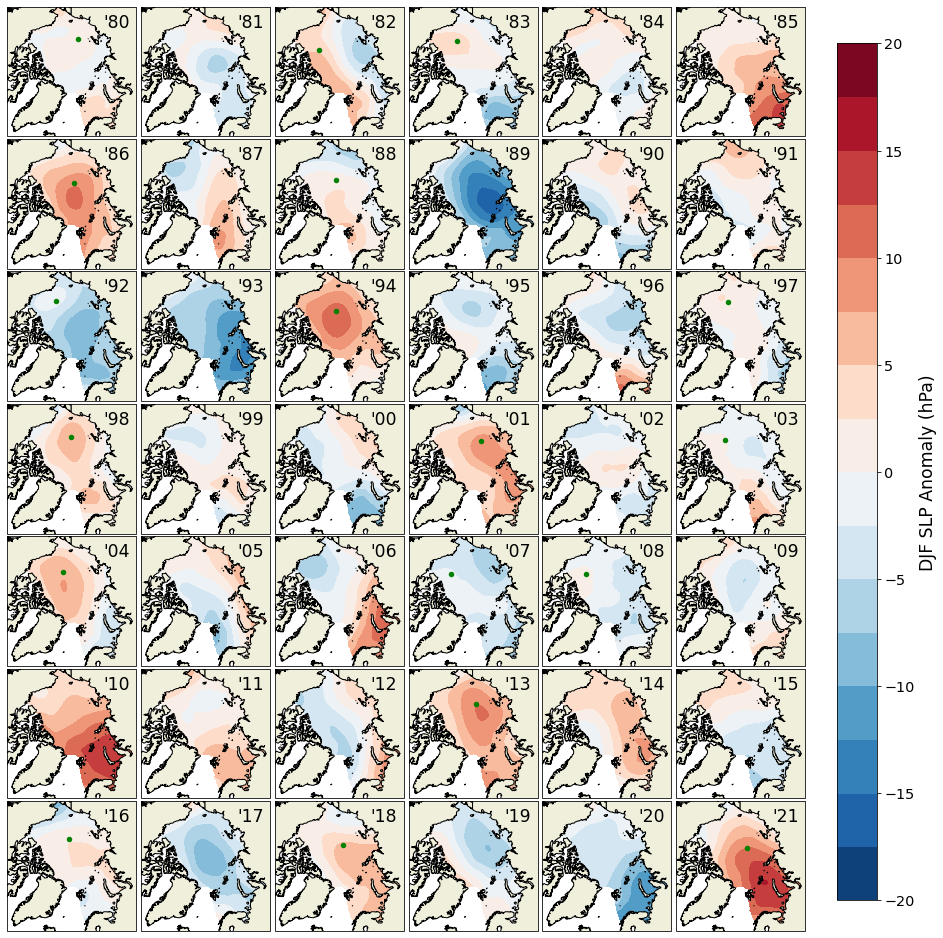

In [24]:
fig, axs = plt.subplots(7,6,figsize=(14,17),  subplot_kw={'projection': ccrs.NorthPolarStereo()})

max_coords = []
max_vals = []
good_years = []

for year, ax in zip(years, axs.reshape(-1)):
    
    sp = winter_slp_patterns[year]
    if year == 2003:
        arr = np.ma.masked_where(ERA5_lon_grid>0,sp)
        arr = np.ma.filled(arr,np.nan)
        argmax = np.unravel_index(np.nanargmax(arr), sp.shape)
    else:
        argmax = np.unravel_index(np.nanargmax(sp), sp.shape)
    
    if check_surroundings(sp, argmax) == False:
#         print(year)
#         print(check_surroundings(sp, argmax))

        lonmax = ERA5_lon_grid[argmax]; latmax = ERA5_lat_grid[argmax]
        
        ax.scatter(lonmax,latmax,color='green',s=20,marker='o',transform=ccrs.PlateCarree(),zorder=6)
        
        max_coords.append((lonmax,latmax))
        max_vals.append(np.nanmax(sp))
        good_years.append(year)
    
    ax.set_extent([-180, 180, 90, 66], ccrs.PlateCarree())

    c = ax.contourf(ERA5_lon_grid,
                    ERA5_lat_grid,
                    (sp - climatology_p)/100,
                    transform=ccrs.PlateCarree(),
                    cmap='RdBu_r',
                    levels=np.arange(-20,21,2.5),
                   )
    
    ax.annotate(f"'{str(year)[-2:]}", xy=(0.95,0.95), ha='right',va='top',
                xycoords='axes fraction',fontsize='xx-large')

    ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)

fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.95, 0.15, 0.04, 0.7])
cb = fig.colorbar(c, cax=cbar_ax)
cb.set_label('DJF SLP Anomaly (hPa)', fontsize='xx-large')
cb.ax.tick_params(labelsize='x-large')

fig.subplots_adjust(wspace=0.01,hspace=0.02)

plt.savefig(f'{overleaf_dir}/Sup_figs/SLP_annual_grid_anom.jpg',dpi=500,bbox_inches='tight')

plt.show()

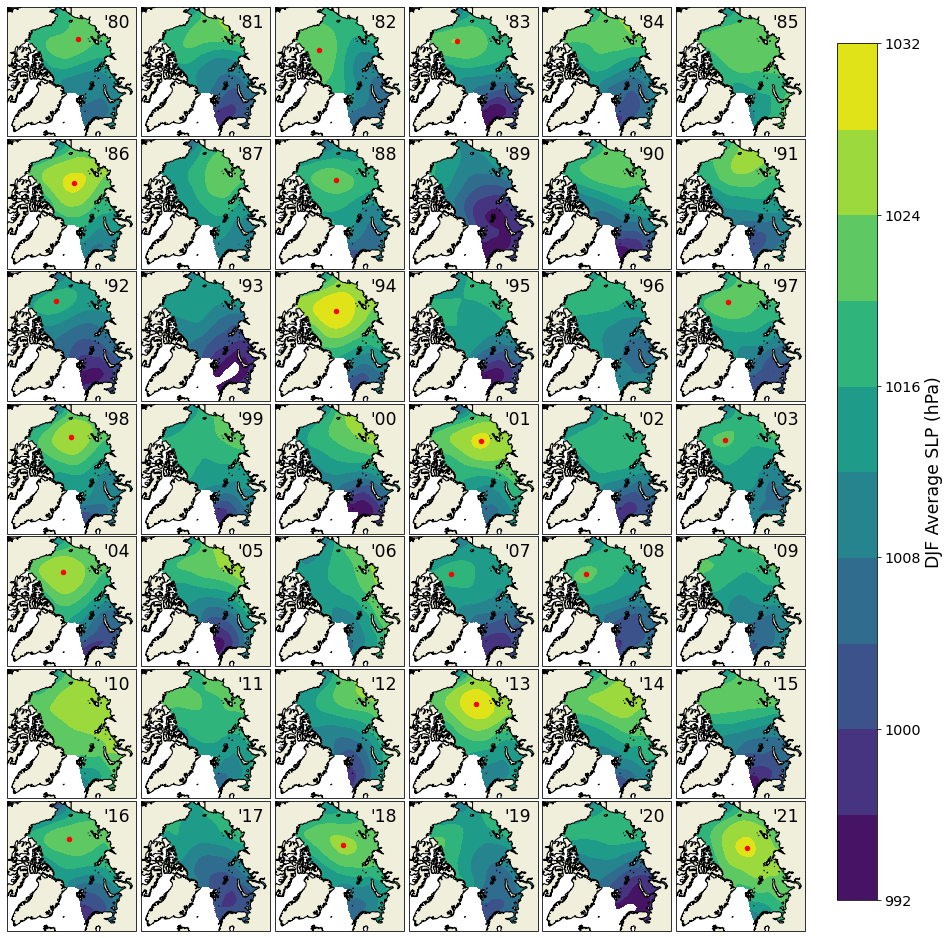

In [17]:
fig, axs = plt.subplots(7,6,figsize=(14,17),  subplot_kw={'projection': ccrs.NorthPolarStereo()})

max_coords = []
max_vals = []
good_years = []

for year, ax in zip(years, axs.reshape(-1)):
    
    sp = winter_slp_patterns[year]
    if year == 2003:
        arr = np.ma.masked_where(ERA5_lon_grid>0,sp)
        arr = np.ma.filled(arr,np.nan)
        argmax = np.unravel_index(np.nanargmax(arr), sp.shape)
    else:
        argmax = np.unravel_index(np.nanargmax(sp), sp.shape)
    
    if check_surroundings(sp, argmax) == False:
#         print(year)
#         print(check_surroundings(sp, argmax))

        lonmax = ERA5_lon_grid[argmax]; latmax = ERA5_lat_grid[argmax]
        
        ax.scatter(lonmax,latmax,color='r',s=20,marker='o',transform=ccrs.PlateCarree(),zorder=6)
        
        max_coords.append((lonmax,latmax))
        max_vals.append(np.nanmax(sp))
        good_years.append(year)
    
    ax.set_extent([-180, 180, 90, 66], ccrs.PlateCarree())

    c = ax.contourf(ERA5_lon_grid,
                    ERA5_lat_grid,
#                     np.zeros(ERA5_lon_grid.shape),
                    sp/100,
                    transform=ccrs.PlateCarree(),
                    levels=np.arange(992,1032.1,4),
                   )
    
    ax.annotate(f"'{str(year)[-2:]}", xy=(0.95,0.95), ha='right',va='top',
                xycoords='axes fraction',fontsize='xx-large')

    ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)

fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.95, 0.15, 0.04, 0.7])
cb = fig.colorbar(c, cax=cbar_ax)
cb.set_label('DJF Average SLP (hPa)', fontsize='xx-large')
cb.ax.tick_params(labelsize='x-large')

fig.subplots_adjust(wspace=0.01,hspace=0.02)

plt.savefig(f'{overleaf_dir}/Sup_figs/SLP_annual_grid.jpg',dpi=500,bbox_inches='tight')

plt.show()

In [18]:
import pandas as pd
df = pd.DataFrame({'Year':good_years,
                   'Max SLP (hPa)':np.round(np.array(max_vals)/100,decimals=1),
                   'Longitude':[i[0] for i in max_coords],
                   'Latitude':[i[1] for i in max_coords]})

pickle.dump(df, open('../pickles/SLP_max_coords.p','wb'))

df

,Year,Max SLP (hPa),Longitude,Latitude
0,1980,1022.3,168.25,77.50
1,1982,1023.6,-138.00,79.00
2,1983,1024.1,-152.50,77.25
3,1986,1029.0,171.25,82.00
4,1988,1021.4,-173.75,81.00
5,1992,1018.6,-157.00,75.75
6,1994,1031.5,-173.00,80.50
7,1997,1023.0,-161.00,76.50
8,1998,1027.6,-180.00,78.00
9,2001,1028.7,163.75,79.25


In [19]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

pickle.dump(max_coords,open('../figure1_current/BSH_points.p','wb'))

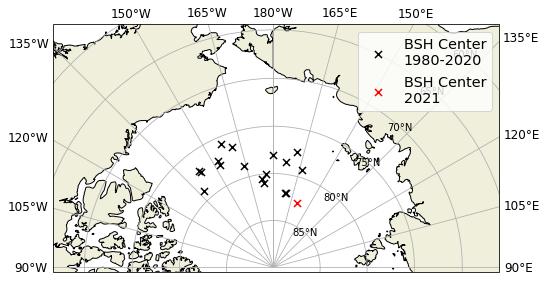

In [20]:
fig, ax = plt.subplots(1,1,figsize=(8,8),  subplot_kw={'projection': ccrs.NorthPolarStereo()})

ax.scatter([x[0] for x in max_coords[:-1]],
           [x[1] for x in max_coords[:-1]],
           color='k',
           s=50,
           marker='x',transform=ccrs.PlateCarree(),zorder=5,
           label='BSH Center\n1980-2020')

ax.scatter([x[0] for x in max_coords[-1:]],
           [x[1] for x in max_coords[-1:]],
           color='r',
           s=50,
           marker='x',transform=ccrs.PlateCarree(),zorder=5,
           label='BSH Center\n2021')

ax.set_extent([-2.633e+06, 2.696e+06, -6e+04, 2.9e+06], crs=ccrs.NorthPolarStereo()) 

ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)

ax.legend(fontsize='x-large')

gl = ax.gridlines(draw_labels=True)

gl.xlocator = mticker.FixedLocator(np.concatenate([np.arange(-180,-89,15),np.arange(90,181,15)]))
gl.xformatter = LONGITUDE_FORMATTER
gl.xlabel_style = {'size': 12, 'color': 'k','rotation':0}

# gl.yformatter = LATITUDE_FORMATTER
# gl.ylocator = mticker.FixedLocator(np.arange(70,86,5),200)

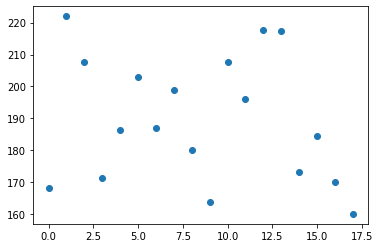

In [21]:
xs = [x[0] if x[0] > 0 else 360 + x[0] for x in max_coords]

plt.scatter(range(len(xs)),xs)

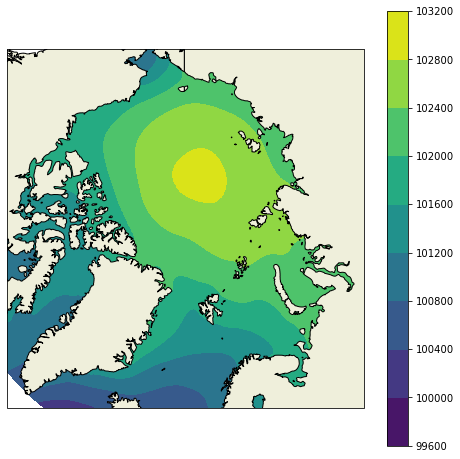

In [22]:
fig = plt.figure(figsize=(8,8))

ax = plt.axes(projection=ccrs.NorthPolarStereo())

ax.set_extent([-180, 180, 90, 66], ccrs.PlateCarree())

c = ax.contourf(ERA5_lon_grid,
            ERA5_lat_grid,
            get_winter_slp_pattern(2021),
            transform=ccrs.PlateCarree(),
            levels=np.arange(99600,103201,400),
               )

ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)

plt.colorbar(c)